# Import

In [1]:
import pandas as pd
import os
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from utils.Perspectiver import Perspectiver
from utils.Loader import CardsDataset
from arquitecture.CardsClassifier import CardClassifier

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/lingfeng/Desktop/venvs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset scale testing

In [2]:
CardsDataset().data.head()

,class index,filepaths,labels,filepaths_full
0,18,train/jack of hearts/149.jpg,jack of hearts,data/train/jack of hearts/149.jpg
1,10,train/five of hearts/120.jpg,five of hearts,data/train/five of hearts/120.jpg
2,9,train/five of diamonds/007.jpg,five of diamonds,data/train/five of diamonds/007.jpg
3,21,train/king of clubs/018.jpg,king of clubs,data/train/king of clubs/018.jpg
4,39,train/six of hearts/049.jpg,six of hearts,data/train/six of hearts/049.jpg


In [3]:
scale_1 = 1
scale_2 = 0.60
dataset_scale_100 = CardsDataset(scale=scale_1)
dataset_scale_050 = CardsDataset(scale=scale_2)

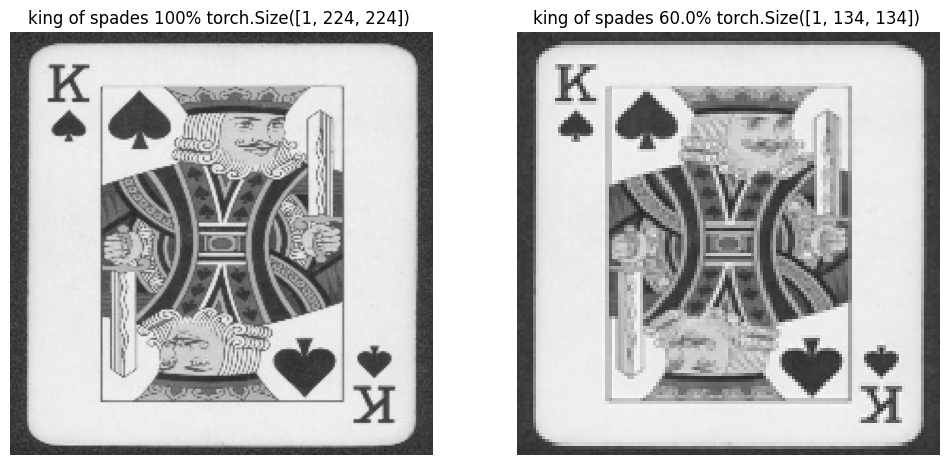

In [4]:
import random
idx = random.randint(0, len(dataset_scale_050))
img_1 , label_1 = dataset_scale_100.__getitem__(idx)
img_2 , label_2 = dataset_scale_050.__getitem__(idx)
Perspectiver.plotComparison(imageBefore = Perspectiver.grayscale_to_rgb(img_1.numpy()[0]) , 
                            imageAfter = Perspectiver.grayscale_to_rgb(img_2.numpy()[0]) , 
                            titleBefore = f"{dataset_scale_100.decode_label(label_1)} {scale_1*100}% {img_1.size()} ",
                            titleAfter = f"{dataset_scale_050.decode_label(label_2)} {scale_2*100}% {img_2.size()} "
                            )

# Training process

## Hyperparameters

In [5]:
EPOCH = 30
BATCH_SIZE = 900
NUN_WORKERS = 6

In [6]:
classifier = CardClassifier(convolution_structure=[1,8,8,16,16,32,32,64,64,128, 128], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=2, 
                            output_len=53).to(DEVICE)

train_dataset = CardsDataset(scale=0.6, split="train")
test_dataset = CardsDataset(scale=0.6, split="test")
valid_dataset = CardsDataset(scale=0.6, split="valid")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUN_WORKERS)

In [7]:
criterion = nn.CrossEntropyLoss(reduction = "sum")

optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [8]:
for epoch in range(EPOCH):
    classifier.train()
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        # Resetear gradientes
        optimizer.zero_grad()
        
        #print(inputs.size())
        #print(labels.size())
        
        # Forward pass
        outputs = classifier(inputs.to(DEVICE))
        #print(outputs.size())
        loss = criterion(outputs, torch.argmax(labels.to(DEVICE), dim=1))
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        # Acumular la pérdida
        train_loss += loss.item() * inputs.size(0)
    
    # Calcular la pérdida promedio del entrenamiento
    train_loss = train_loss / len(train_dataset)
    
    # Modo evaluación para el conjunto de validación
    classifier.eval()
    valid_loss = 0.0
    correct = 0
    
    #print("Validating...")
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = classifier(inputs.to(DEVICE))
            loss = criterion(outputs, torch.argmax(labels.to(DEVICE), dim=1))
            valid_loss += loss.item() * inputs.size(0)
            
            #print("model output: ",outputs.size())
            #print("labels:", labels.size())
            
            x, preds = torch.max(outputs, dim=1)
            #print("x output: ",x.size())
            #print("preds output: ",preds.size())
            correct += (preds == torch.argmax(labels.to(DEVICE), dim=1)).sum().item()
    
    valid_loss = valid_loss / len(valid_dataset)
    valid_acc = correct / len(valid_dataset)
    
    print(f"Época {epoch+1}/{EPOCH} - Pérdida Entrenamiento: {train_loss:.4f} - Pérdida Validación: {valid_loss:.4f} - Precisión Validación: {valid_acc:.4f}")

Época 1/30 - Pérdida Entrenamiento: 3467.0318 - Pérdida Validación: 1052.2074 - Precisión Validación: 0.0189
Época 2/30 - Pérdida Entrenamiento: 3446.6249 - Pérdida Validación: 1052.2047 - Precisión Validación: 0.0189
Época 3/30 - Pérdida Entrenamiento: 3421.8820 - Pérdida Validación: 1052.2915 - Precisión Validación: 0.0189
Época 4/30 - Pérdida Entrenamiento: 3414.6933 - Pérdida Validación: 1052.4907 - Precisión Validación: 0.0189
Época 5/30 - Pérdida Entrenamiento: 3400.8540 - Pérdida Validación: 1053.5088 - Precisión Validación: 0.0189
Época 6/30 - Pérdida Entrenamiento: 3366.9861 - Pérdida Validación: 1051.1761 - Precisión Validación: 0.0302
Época 7/30 - Pérdida Entrenamiento: 3334.4188 - Pérdida Validación: 1082.8676 - Precisión Validación: 0.0189
Época 8/30 - Pérdida Entrenamiento: 3303.5662 - Pérdida Validación: 1534.0219 - Precisión Validación: 0.0189
Época 9/30 - Pérdida Entrenamiento: 3280.6730 - Pérdida Validación: 2398.9688 - Precisión Validación: 0.0189
Época 10/30 - Pérdi